In [152]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from neo4j import GraphDatabase
import random
import warnings
warnings.filterwarnings('ignore')

# Deutsche Visualisierungseinstellungen
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

In [2]:
# ==============================================================================
# 1. NEO4J VERBINDUNG UND DATENEXTRAKTION (AKTUALISIERT)
# ==============================================================================

class BundestagAnalyzer:
    def __init__(self, uri="bolt://localhost:7687", username="neo4j", password="bundestag_password"):
        self.driver = GraphDatabase.driver(uri, auth=(username, password))
    
    def close(self):
        self.driver.close()
    
    def extract_politician_data(self):
        """Extrahiert alle relevanten Politikerdaten aus Neo4j mit aktualisierten Feldern"""
        query = """
        MATCH (p:Politician)-[:HAS_MANDATE]->(m:Mandate)
        MATCH (m)-[:IN_PERIOD]->(period:Period)
        MATCH (m)-[:AFFILIATED_WITH]->(party:Party)
        OPTIONAL MATCH (m)-[:REPRESENTS_STATE]->(state:State)
        OPTIONAL MATCH (m)-[:REPRESENTS_CONSTITUENCY]->(const:Constituency)
        OPTIONAL MATCH (p)-[:HAS_CLASSIFICATION]->(c:Classification)
        RETURN 
            p.firstname as firstname,
            p.lastname as lastname, 
            p.full_name as full_name,
            p.birth_year as birth_year,
            p.death_year as death_year,
            p.geschlecht as geschlecht,
            p.geschlecht_confidence as geschlecht_confidence,
            period.name as period_name,
            period.number as period_number,
            period.start_jahr as period_start_year,
            period.ende_jahr as period_end_year,
            period.dauer as period_duration,
            party.name as party_name,
            state.name as state_name,
            const.name as constituency_name,
            m.political_party as mandate_party,
            m.constituency as mandate_constituency,
            m.federate_state as mandate_state,
            c.dqr_level as dqr_level,
            c.confidence as classification_confidence,
            c.comment as classification_comment
        """
        
        with self.driver.session() as session:
            result = session.run(query)
            return pd.DataFrame([record.data() for record in result])
    
    def extract_period_data(self):
        """Extrahiert detaillierte Periodendetails"""
        query = """
        MATCH (period:Period)
        RETURN 
            period.name as period_name, 
            period.number as period_number,
            period.start_jahr as start_year,
            period.ende_jahr as end_year,
            period.dauer as duration
        ORDER BY period.number
        """
        
        with self.driver.session() as session:
            result = session.run(query)
            return pd.DataFrame([record.data() for record in result])

In [45]:
bundesanalyser = BundestagAnalyzer()
df = bundesanalyser.extract_politician_data()
df.head()

,firstname,lastname,full_name,birth_year,death_year,geschlecht,geschlecht_confidence,period_name,period_number,period_start_year,...,period_duration,party_name,state_name,constituency_name,mandate_party,mandate_constituency,mandate_state,dqr_level,classification_confidence,classification_comment
0,Gerd,Bucerius,Gerd Bucerius,1906,1995,männlich,0.90,Liste der Mitglieder des Deutschen Bundestages...,1,1949,...,4,CDU,Hamburg,Hamburg III,CDU,Hamburg III,Hamburg,8.0,3.0,Dr. iur. (Promotion in Rechtswissenschaft)
1,Bernhard,Winkelheide,Bernhard Winkelheide,1908,1988,männlich,0.95,Liste der Mitglieder des Deutschen Bundestages...,1,1949,...,4,CDU,Nordrhein-Westfalen,Recklinghausen-Stadt,CDU,Recklinghausen-Stadt,Nordrhein-Westfalen,4.0,3.0,Ausbildung zum Maschinenschlosser (duale Beruf...
2,Hans,Wellhausen,Hans Wellhausen,1894,1964,männlich,0.99,Liste der Mitglieder des Deutschen Bundestages...,1,1949,...,4,FDP,Bayern,None,FDP,,Bayern,7.0,3.0,Volljurist mit 2. Staatsexamen
3,Ernst,Zuhlke,Ernst Zühlke,1895,1976,männlich,0.95,Liste der Mitglieder des Deutschen Bundestages...,1,1949,...,4,SPD,Bayern,Coburg,SPD,Coburg,Bayern,6.0,2.0,Fortbildung an Fachschule für Wirtschaft und V...
4,Georg-August,Zinn,Georg-August Zinn,1901,1976,männlich,0.95,Liste der Mitglieder des Deutschen Bundestages...,1,1949,...,4,SPD,Hessen,Kassel,SPD,Kassel,Hessen,7.0,3.0,Volljurist mit 2. Staatsexamen


In [49]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12533 entries, 0 to 12532
Data columns (total 34 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   firstname                   12532 non-null  string 
 1   lastname                    12532 non-null  string 
 2   full_name                   12533 non-null  string 
 3   birth_year                  12533 non-null  int64  
 4   death_year                  5973 non-null   Int64  
 5   geschlecht                  12533 non-null  string 
 6   geschlecht_confidence       12533 non-null  float64
 7   period_name                 12533 non-null  string 
 8   period_number               12533 non-null  int64  
 9   period_start_year           12533 non-null  int64  
 10  period_end_year             12533 non-null  int64  
 11  period_duration             12533 non-null  int64  
 12  party_name                  12533 non-null  string 
 13  state_name                  125

In [47]:
# ==============================================================================
# 2. DATENAUFBEREITUNG UND FEATURE ENGINEERING (VERBESSERT)
# ==============================================================================

def prepare_data(df):
    """Bereitet die Daten für die Analyse vor - mit echten Geschlechtsdaten"""
    
    # Datentypen korrigieren
    print("🔧 Konvertiere Datentypen...")
    
    # Numerische Spalten konvertieren
    numeric_columns = {
        'birth_year': 'int64',
        'death_year': 'Int64',  # Nullable integer für NaN-Werte
        'period_number': 'int64',
        'dqr_level': 'Int64'  # Nullable integer für NaN-Werte
    }
    
    for col, dtype in numeric_columns.items():
        if col in df.columns:
            try:
                if dtype == 'Int64':  # Nullable integer
                    df[col] = pd.to_numeric(df[col], errors='coerce').astype(dtype)
                else:
                    df[col] = pd.to_numeric(df[col], errors='coerce').astype(dtype)
                print(f"✅ {col} konvertiert zu {dtype}")
            except Exception as e:
                print(f"⚠️  Warnung: Konvertierung von {col} fehlgeschlagen: {e}")
    
    # Float-Spalten sind bereits korrekt (geschlecht_confidence, classification_confidence)
    
    # String-Spalten explizit als string definieren
    string_columns = ['firstname', 'lastname', 'full_name', 'period_name', 
                     'party_name', 'state_name', 'constituency_name', 
                     'mandate_party', 'mandate_constituency', 'mandate_state',
                     'classification_comment', 'geschlecht']
    
    for col in string_columns:
        if col in df.columns:
            df[col] = df[col].astype('string')
    
    # Datentyp-Check ausgeben
    print("\n📊 Datentypen nach Konvertierung:")
    for col in ['birth_year', 'death_year', 'period_number', 'dqr_level', 
               'geschlecht_confidence', 'classification_confidence']:
        if col in df.columns:
            print(f"   {col}: {df[col].dtype}")
    
    # Aktuelles Jahr für Altersberechnung
    current_year = 2025
    
    # Exakte Altersberechnung basierend auf Periodenstart
    df['age_at_period_start'] = df['period_start_year'] - df['birth_year']
    df['age_at_period_end'] = df['period_end_year'] - df['birth_year']
    df['age_at_mandate'] = df['age_at_period_start']  # Für Kompatibilität
    df['current_age'] = current_year - df['birth_year']
    df['is_deceased'] = df['death_year'].notna()
    
    # Geschlecht normalisieren (echte Daten verwenden)
    def normalize_gender(geschlecht):
        if pd.isna(geschlecht):
            return 'Unbekannt'
        gender_lower = str(geschlecht).lower()
        if gender_lower in ['m', 'male', 'mann', 'männlich']:
            return 'Männlich'
        elif gender_lower in ['f', 'w', 'female', 'frau', 'weiblich']:
            return 'Weiblich'
        else:
            return 'Divers/Unbekannt'
    
    df['gender_normalized'] = df['geschlecht'].apply(normalize_gender)
    
    # Geschlechts-Konfidenz kategorisieren
    def confidence_category(conf):
        if pd.isna(conf):
            return 'Unbekannt'
        elif conf >= 0.9:
            return 'Sehr hoch (≥0.9)'
        elif conf >= 0.8:
            return 'Hoch (0.8-0.89)'
        elif conf >= 0.7:
            return 'Mittel (0.7-0.79)'
        else:
            return 'Niedrig (<0.7)'
    
    df['gender_confidence_category'] = df['geschlecht_confidence'].apply(confidence_category)
    
    # Parteien direkt aus der Datenbank verwenden (bereits kategorisiert)
    df['party_category'] = df['party_name'].fillna('Unbekannt')
    
    # CDU/CSU Union für manche Analysen
    df['party_union'] = df['party_category'].apply(
        lambda x: 'CDU/CSU' if x in ['CDU', 'CSU'] else x
    )
    
    # DQR Level kategorisieren (Bildungsabschluss-Proxy)
    def education_level(dqr):
        if pd.isna(dqr):
            return 'Unbekannt'
        elif dqr <= 2:
            return 'Grundbildung (DQR 1-2)'
        elif dqr <= 4:
            return 'Berufliche Bildung (DQR 3-4)'
        elif dqr == 5:
            return 'Berufliche Spezialisierung (DQR 5)'
        elif dqr == 6:
            return 'Bachelor/Meister (DQR 6)'
        elif dqr == 7:
            return 'Master (DQR 7)'
        else:
            return 'Promotion (DQR 8)'
    
    df['education_category'] = df['dqr_level'].apply(education_level)
    
    # Akademiker-Flag (DQR 6+)
    df['is_academic'] = df['dqr_level'] >= 6
    
    # Wahlperioden-Epochen (basierend auf tatsächlichen Startjahren)
    # Startjahre: [1949, 1953, 1957, 1961, 1965, 1969, 1972, 1976, 1980, 1983, 1987, 1990, 1994, 1998, 2002, 2005, 2009, 2013, 2017, 2021]
    def period_epoch(start_year):
        if pd.isna(start_year):
            return 'Unbekannt'
        elif start_year < 1961:
            return 'Adenauer-Ära (1949-1961)'
        elif start_year < 1969:
            return 'Erhard/Kiesinger (1961-1969)'
        elif start_year < 1982:
            return 'Brandt/Schmidt (1969-1982)'
        elif start_year < 1998:
            return 'Kohl-Ära (1982-1998)'
        elif start_year < 2013:
            return 'Schröder/Merkel I (1998-2013)'
        else:
            return 'Merkel II/Scholz (2013-heute)'
    
    df['period_epoch'] = df['period_start_year'].apply(period_epoch)
    
    # Generationen definieren
    def generation(birth_year):
        if pd.isna(birth_year):
            return 'Unbekannt'
        elif birth_year < 1930:
            return 'Vorkriegsgeneration (vor 1930)'
        elif birth_year < 1945:
            return 'Kriegsgeneration (1930-1944)'
        elif birth_year < 1965:
            return 'Babyboomer (1945-1964)'
        elif birth_year < 1980:
            return 'Generation X (1965-1979)'
        elif birth_year < 1995:
            return 'Millennials (1980-1994)'
        else:
            return 'Generation Z (ab 1995)'
    
    df['generation'] = df['birth_year'].apply(generation)
    
    return df

In [48]:
clean_df = prepare_data(df)

🔧 Konvertiere Datentypen...
✅ birth_year konvertiert zu int64
✅ death_year konvertiert zu Int64
✅ period_number konvertiert zu int64
✅ dqr_level konvertiert zu Int64

📊 Datentypen nach Konvertierung:
   birth_year: int64
   death_year: Int64
   period_number: int64
   dqr_level: Int64
   geschlecht_confidence: float64
   classification_confidence: float64


In [30]:
clean_df.head()

,firstname,lastname,full_name,birth_year,death_year,geschlecht,geschlecht_confidence,period_name,period_number,period_start_year,...,current_age,is_deceased,gender_normalized,gender_confidence_category,party_category,party_union,education_category,is_academic,period_epoch,generation
0,Gerd,Bucerius,Gerd Bucerius,1906,1995,männlich,0.90,Liste der Mitglieder des Deutschen Bundestages...,1,1949,...,119,True,Männlich,Sehr hoch (≥0.9),CDU,CDU/CSU,Promotion (DQR 8),True,Adenauer-Ära (1949-1961),Vorkriegsgeneration (vor 1930)
1,Bernhard,Winkelheide,Bernhard Winkelheide,1908,1988,männlich,0.95,Liste der Mitglieder des Deutschen Bundestages...,1,1949,...,117,True,Männlich,Sehr hoch (≥0.9),CDU,CDU/CSU,Berufliche Bildung (DQR 3-4),False,Adenauer-Ära (1949-1961),Vorkriegsgeneration (vor 1930)
2,Hans,Wellhausen,Hans Wellhausen,1894,1964,männlich,0.99,Liste der Mitglieder des Deutschen Bundestages...,1,1949,...,131,True,Männlich,Sehr hoch (≥0.9),FDP,FDP,Master (DQR 7),True,Adenauer-Ära (1949-1961),Vorkriegsgeneration (vor 1930)
3,Ernst,Zuhlke,Ernst Zühlke,1895,1976,männlich,0.95,Liste der Mitglieder des Deutschen Bundestages...,1,1949,...,130,True,Männlich,Sehr hoch (≥0.9),SPD,SPD,Bachelor/Meister (DQR 6),True,Adenauer-Ära (1949-1961),Vorkriegsgeneration (vor 1930)
4,Georg-August,Zinn,Georg-August Zinn,1901,1976,männlich,0.95,Liste der Mitglieder des Deutschen Bundestages...,1,1949,...,124,True,Männlich,Sehr hoch (≥0.9),SPD,SPD,Master (DQR 7),True,Adenauer-Ära (1949-1961),Vorkriegsgeneration (vor 1930)


In [31]:
clean_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12533 entries, 0 to 12532
Data columns (total 34 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   firstname                   12532 non-null  string 
 1   lastname                    12532 non-null  string 
 2   full_name                   12533 non-null  string 
 3   birth_year                  12533 non-null  int64  
 4   death_year                  5973 non-null   Int64  
 5   geschlecht                  12533 non-null  string 
 6   geschlecht_confidence       12533 non-null  float64
 7   period_name                 12533 non-null  string 
 8   period_number               12533 non-null  int64  
 9   period_start_year           12533 non-null  int64  
 10  period_end_year             12533 non-null  int64  
 11  period_duration             12533 non-null  int64  
 12  party_name                  12533 non-null  string 
 13  state_name                  125

In [32]:
clean_df.columns

Index(['firstname', 'lastname', 'full_name', 'birth_year', 'death_year',
       'geschlecht', 'geschlecht_confidence', 'period_name', 'period_number',
       'period_start_year', 'period_end_year', 'period_duration', 'party_name',
       'state_name', 'constituency_name', 'mandate_party',
       'mandate_constituency', 'mandate_state', 'dqr_level',
       'classification_confidence', 'classification_comment',
       'age_at_period_start', 'age_at_period_end', 'age_at_mandate',
       'current_age', 'is_deceased', 'gender_normalized',
       'gender_confidence_category', 'party_category', 'party_union',
       'education_category', 'is_academic', 'period_epoch', 'generation'],
      dtype='object')

In [33]:
clean_df['period_number'].unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21])

In [34]:
df.groupby(['period_start_year', 'gender_normalized'])['age_at_mandate'].mean()

period_start_year  gender_normalized
1949               Divers/Unbekannt     49.000000
                   Männlich             50.237864
                   Weiblich             49.323529
1953               Divers/Unbekannt     48.333333
                   Männlich             50.601253
                                          ...    
2021               Männlich             48.402655
                   Weiblich             45.760000
2025               Divers/Unbekannt     44.666667
                   Männlich             49.193069
                   Weiblich             45.894737
Name: age_at_mandate, Length: 63, dtype: float64

In [35]:
df.groupby('period_start_year')['gender_normalized'].value_counts(normalize=True)

period_start_year  gender_normalized
1949               Männlich             0.917595
                   Weiblich             0.075724
                   Divers/Unbekannt     0.006682
1953               Männlich             0.902072
                   Weiblich             0.092279
                                          ...   
2021               Weiblich             0.346260
                   Divers/Unbekannt     0.027701
2025               Männlich             0.653722
                   Weiblich             0.307443
                   Divers/Unbekannt     0.038835
Name: proportion, Length: 63, dtype: float64

In [36]:
gender_by_year = df.groupby('period_start_year')['gender_normalized'].value_counts(normalize=True).unstack(fill_value=0) * 100
gender_by_year

gender_normalized,Divers/Unbekannt,Männlich,Weiblich
period_start_year,,,
1949,0.668151,91.759465,7.572383
1953,0.564972,90.207156,9.227872
1957,0.370370,90.925926,8.703704
1961,0.900901,89.909910,9.189189
1965,0.932836,91.044776,8.022388
1969,1.132075,92.264151,6.603774
1972,0.766284,92.145594,7.088123
1976,0.754717,91.509434,7.735849
1980,1.520913,89.733840,8.745247


In [132]:
df.groupby(['period_start_year', 'gender_normalized'])['is_academic'].mean().unstack(fill_value=0) * 100

gender_normalized,Divers/Unbekannt,Männlich,Weiblich
period_start_year,,,
1949,33.333333,51.941748,47.058824
1953,33.333333,56.158664,42.857143
1957,50.0,55.600815,42.553191
1961,60.0,56.312625,43.137255
1965,80.0,58.110883,44.186047
1969,83.333333,62.576687,42.857143
1972,100.0,70.27027,59.459459
1976,75.0,74.43299,73.170732
1980,87.5,76.271186,67.391304


In [211]:
# ==============================================================================
# 3. DQR LEVEL ANALYSEN
# ==============================================================================

def dqr_level_analysis(df):
    """Führt erweiterte numerische Analysen durch"""
    
    fig, axes = plt.subplots(3, 2, figsize=(20, 22))
    fig.suptitle('DQR Level Analyse der Bundestagsmitglieder', fontsize=16, fontweight='bold', y=1)
    
    # 1. Akademisierung über Zeit
    ax5 = axes[0, 0]
    academic_by_year = df.groupby('period_start_year')['is_academic'].mean() * 100

    # Akademikerquote nach Geschlecht (gender_normalized)
    academic_by_year_gender = (
        df.groupby(['period_start_year', 'gender_normalized'])['is_academic']
        .mean()
        .unstack(fill_value=0) * 100
    )

    # Gesamtdurchschnitt
    ax5.plot(academic_by_year.index, academic_by_year.values, 
            marker='o', linewidth=2, markersize=8, color='darkgreen', label='Alle')

    # Männlich Akademiker
    if 'Männlich' in academic_by_year_gender.columns:
        ax5.plot(
            academic_by_year_gender.index,
            academic_by_year_gender['Männlich'],
            marker='s', linewidth=1, markersize=7, color='blue', label='Männlich', alpha=0.5
        )

    # Weiblich Akademiker
    if 'Weiblich' in academic_by_year_gender.columns:
        ax5.plot(
            academic_by_year_gender.index,
            academic_by_year_gender['Weiblich'],
            marker='^', linewidth=1, markersize=7, color='magenta', label='Weiblich', alpha=0.5
        )

    ax5.set_xlabel('Jahr (Periodenbeginn)')
    ax5.set_ylabel('Anteil Akademiker (%)')
    ax5.set_title('Akademisierung des Bundestags über Zeit')
    ax5.grid(True, alpha=0.3)
    
    # Deutsche Bevölkerung als Referenz (geschätzte Werte)
    # https://de.wikipedia.org/wiki/Akademikerquote
    # https://www.iwd.de/artikel/der-trend-geht-zum-akademiker-334262/
    ref_years = [1950, 1970, 1990, 2005, 2014, 2016, 2022]
    ref_academic = [5, 7, 12, 15, 19, 21, 24]  # Geschätzte Akademikerquote in Deutschland
    ax5.plot(ref_years, ref_academic, '--', color='red', linewidth=2, 
            label='Deutsche Bevölkerung (geschätzt)', alpha=0.7)
    ax5.legend()


    # 2. Akademikerquote nach Parteien über Zeit
    ax4 = axes[0, 1]
    academic_party_time = df.groupby(['period_start_year', 'party_category'])['is_academic'].mean() * 100

    academic_party_time = academic_party_time.unstack()
    party_time = pd.crosstab(df['period_start_year'], df['party_category'])
    main_parties_ac = party_time.sum().nlargest(8).index
    # Automatisch verschiedene Farben für jede Partei zuweisen
    color_cycle = plt.cm.get_cmap('tab10', len(main_parties_ac))
    for idx, party in enumerate(main_parties_ac):
        if party in academic_party_time.columns:
            ax4.plot(
                academic_party_time.index,
                academic_party_time[party],
                marker='o',
                linewidth=0.5,
                label=party,
                color=color_cycle(idx),
                alpha=random.uniform(0.8, 0.95)
            )
    
    ax4.set_xlabel('Jahr (Periodenbeginn)')
    ax4.set_ylabel('Akademikerquote (%)')
    ax4.set_title('Akademikerquote nach Parteien über Zeit')
    ax4.legend()
    ax4.grid(True, alpha=0.3)


    # 3. Bildungsverteilung nach Geschlecht
    ax3 = axes[1, 0]
    education_order = [
        'Promotion (DQR 8)',
        'Master (DQR 7)',
        'Bachelor/Meister (DQR 6)',
        'Berufliche Spezialisierung (DQR 5)',
        'Berufliche Bildung (DQR 3-4)',
        'Grundbildung (DQR 1-2)',
        'Unbekannt'
    ]

    df_gender_filtered = df[df['gender_normalized'].isin(['Weiblich', 'Männlich'])]
    education_gender = pd.crosstab(df_gender_filtered['education_category'], df_gender_filtered['gender_normalized'])
    education_gender = education_gender.reindex(education_order)  # descending order
    education_gender_pct = education_gender.div(education_gender.sum(axis=0), axis=1) * 100
    
    education_gender_pct.plot(kind='bar', ax=ax3, color=['skyblue', 'pink', 'lightgreen'], 
                             width=0.8, alpha=0.8)
    ax3.set_xlabel('Bildungsniveau')
    ax3.set_ylabel('Anteil (%)')
    ax3.set_title('Bildungsverteilung nach Geschlecht')
    ax3.legend(title='Geschlecht')
    ax3.tick_params(axis='x', rotation=45)
    ax3.grid(True, alpha=0.3)

    # 4. Anteil Akademiker:innen pro Bundesland (vertical barplot)
    ax4 = axes[1, 1]
    # Anteil Akademiker:innen pro Bundesland berechnen
    state_academic = df.groupby('state_name')['is_academic'].mean().sort_values(ascending=False) * 100
    state_academic.plot(kind='bar', ax=ax4, color='mediumseagreen', alpha=0.8)
    ax4.set_xlabel('Bundesland')
    ax4.set_ylabel('Anteil Akademiker:innen (%)')
    ax4.set_title('Anteil Akademiker:innen pro Bundesland')
    ax4.tick_params(axis='x', rotation=80)
    ax4.grid(True, alpha=0.3)

    # 5. Bildungsexpansion: Promotion vs. andere Abschlüsse
    ax3 = axes[2, 0]
    # Gesamtquote
    phd_ratio_time = df.groupby('period_start_year').apply(
        lambda x: (x['education_category'] == 'Promotion (DQR 8)').mean() * 100
    )
    # Nach Geschlecht
    phd_ratio_time_m = df[df['gender_normalized'] == 'Männlich'].groupby('period_start_year').apply(
        lambda x: (x['education_category'] == 'Promotion (DQR 8)').mean() * 100
    )
    phd_ratio_time_w = df[df['gender_normalized'] == 'Weiblich'].groupby('period_start_year').apply(
        lambda x: (x['education_category'] == 'Promotion (DQR 8)').mean() * 100
    )
    
    ax3.plot(phd_ratio_time.index, phd_ratio_time.values, 
            marker='o', linewidth=2, markersize=8, color='navy', label='Gesamt', alpha=0.8)
    ax3.plot(phd_ratio_time_m.index, phd_ratio_time_m.values, 
            marker='s', linewidth=1, markersize=6, color='royalblue', label='Männlich', alpha=0.8)
    ax3.plot(phd_ratio_time_w.index, phd_ratio_time_w.values, 
            marker='^', linewidth=1, markersize=6, color='deeppink', label='Weiblich', alpha=0.8)
    ax3.set_xlabel('Jahr (Periodenbeginn)')
    ax3.set_ylabel('Promotionsquote (%)')
    ax3.set_title('Promovierte im Bundestag über Zeit')
    ax3.grid(True, alpha=0.3)
    
    # Deutsche Bevölkerung als Referenz (geschätzte Promotionsquote)
    # https://de.wikipedia.org/wiki/Promotion_(Doktor)
    ref_years = [1950, 1970, 1990, 2010, 2021]
    ref_phd = [0.5, 1.0, 1.5, 2.5, 3.0]  # Geschätzte Promotionsquote in Deutschland
    ax3.plot(ref_years, ref_phd, '--', color='red', linewidth=2, 
            label='Deutsche Bevölkerung (geschätzt)', alpha=0.7)
    ax3.legend()
    
    # 6. Durchschnittliche Mandatsanzahl nach Bildungsabschluss (education_category)
    ax6 = axes[2, 1]
    # Berechne die durchschnittliche Mandatsanzahl pro Bildungskategorie
    mandates_per_person = df.groupby('education_category')['full_name'].count() / df.groupby('education_category')['full_name'].nunique()
    # Sortiere nach der gewünschten Reihenfolge
    mandates_per_person = mandates_per_person.reindex(education_order)
    mandates_per_person.plot(kind='bar', ax=ax6, color='slateblue', alpha=0.8)
    ax6.set_xlabel('Bildungsabschluss (DQR-Kategorie)')
    ax6.set_ylabel('Ø Mandate pro Person')
    ax6.set_title('Durchschnittliche Mandatsanzahl nach Bildungsabschluss')
    ax6.tick_params(axis='x', rotation=30)
    ax6.grid(True, alpha=0.3)

    
    plt.tight_layout()
    plt.savefig('plots/dqr_level_analysis.png')
    plt.show()
    
    
    # Erweiterte Statistiken
    print("=== NUMERISCHE STATISTIKEN (ERWEITERT) ===")
    print(f"Durchschnittsalter bei Mandatsantritt: {df['age_at_mandate'].mean():.1f} Jahre")
    print(f"Medianalter bei Mandatsantritt: {df['age_at_mandate'].median():.1f} Jahre")
    print(f"Jüngster Abgeordneter: {df['age_at_mandate'].min():.0f} Jahre")
    print(f"Ältester Abgeordneter: {df['age_at_mandate'].max():.0f} Jahre")
    
    # Geschlechtsstatistiken
    gender_stats = df.groupby('gender_normalized')['age_at_mandate'].agg(['mean', 'median', 'std'])
    print("\nGESCHLECHTSSPEZIFISCHE ALTERSSTATISTIKEN:")
    for gender, stats in gender_stats.iterrows():
        print(f"  {gender}: Ø {stats['mean']:.1f} Jahre (Median: {stats['median']:.1f}, σ: {stats['std']:.1f})")


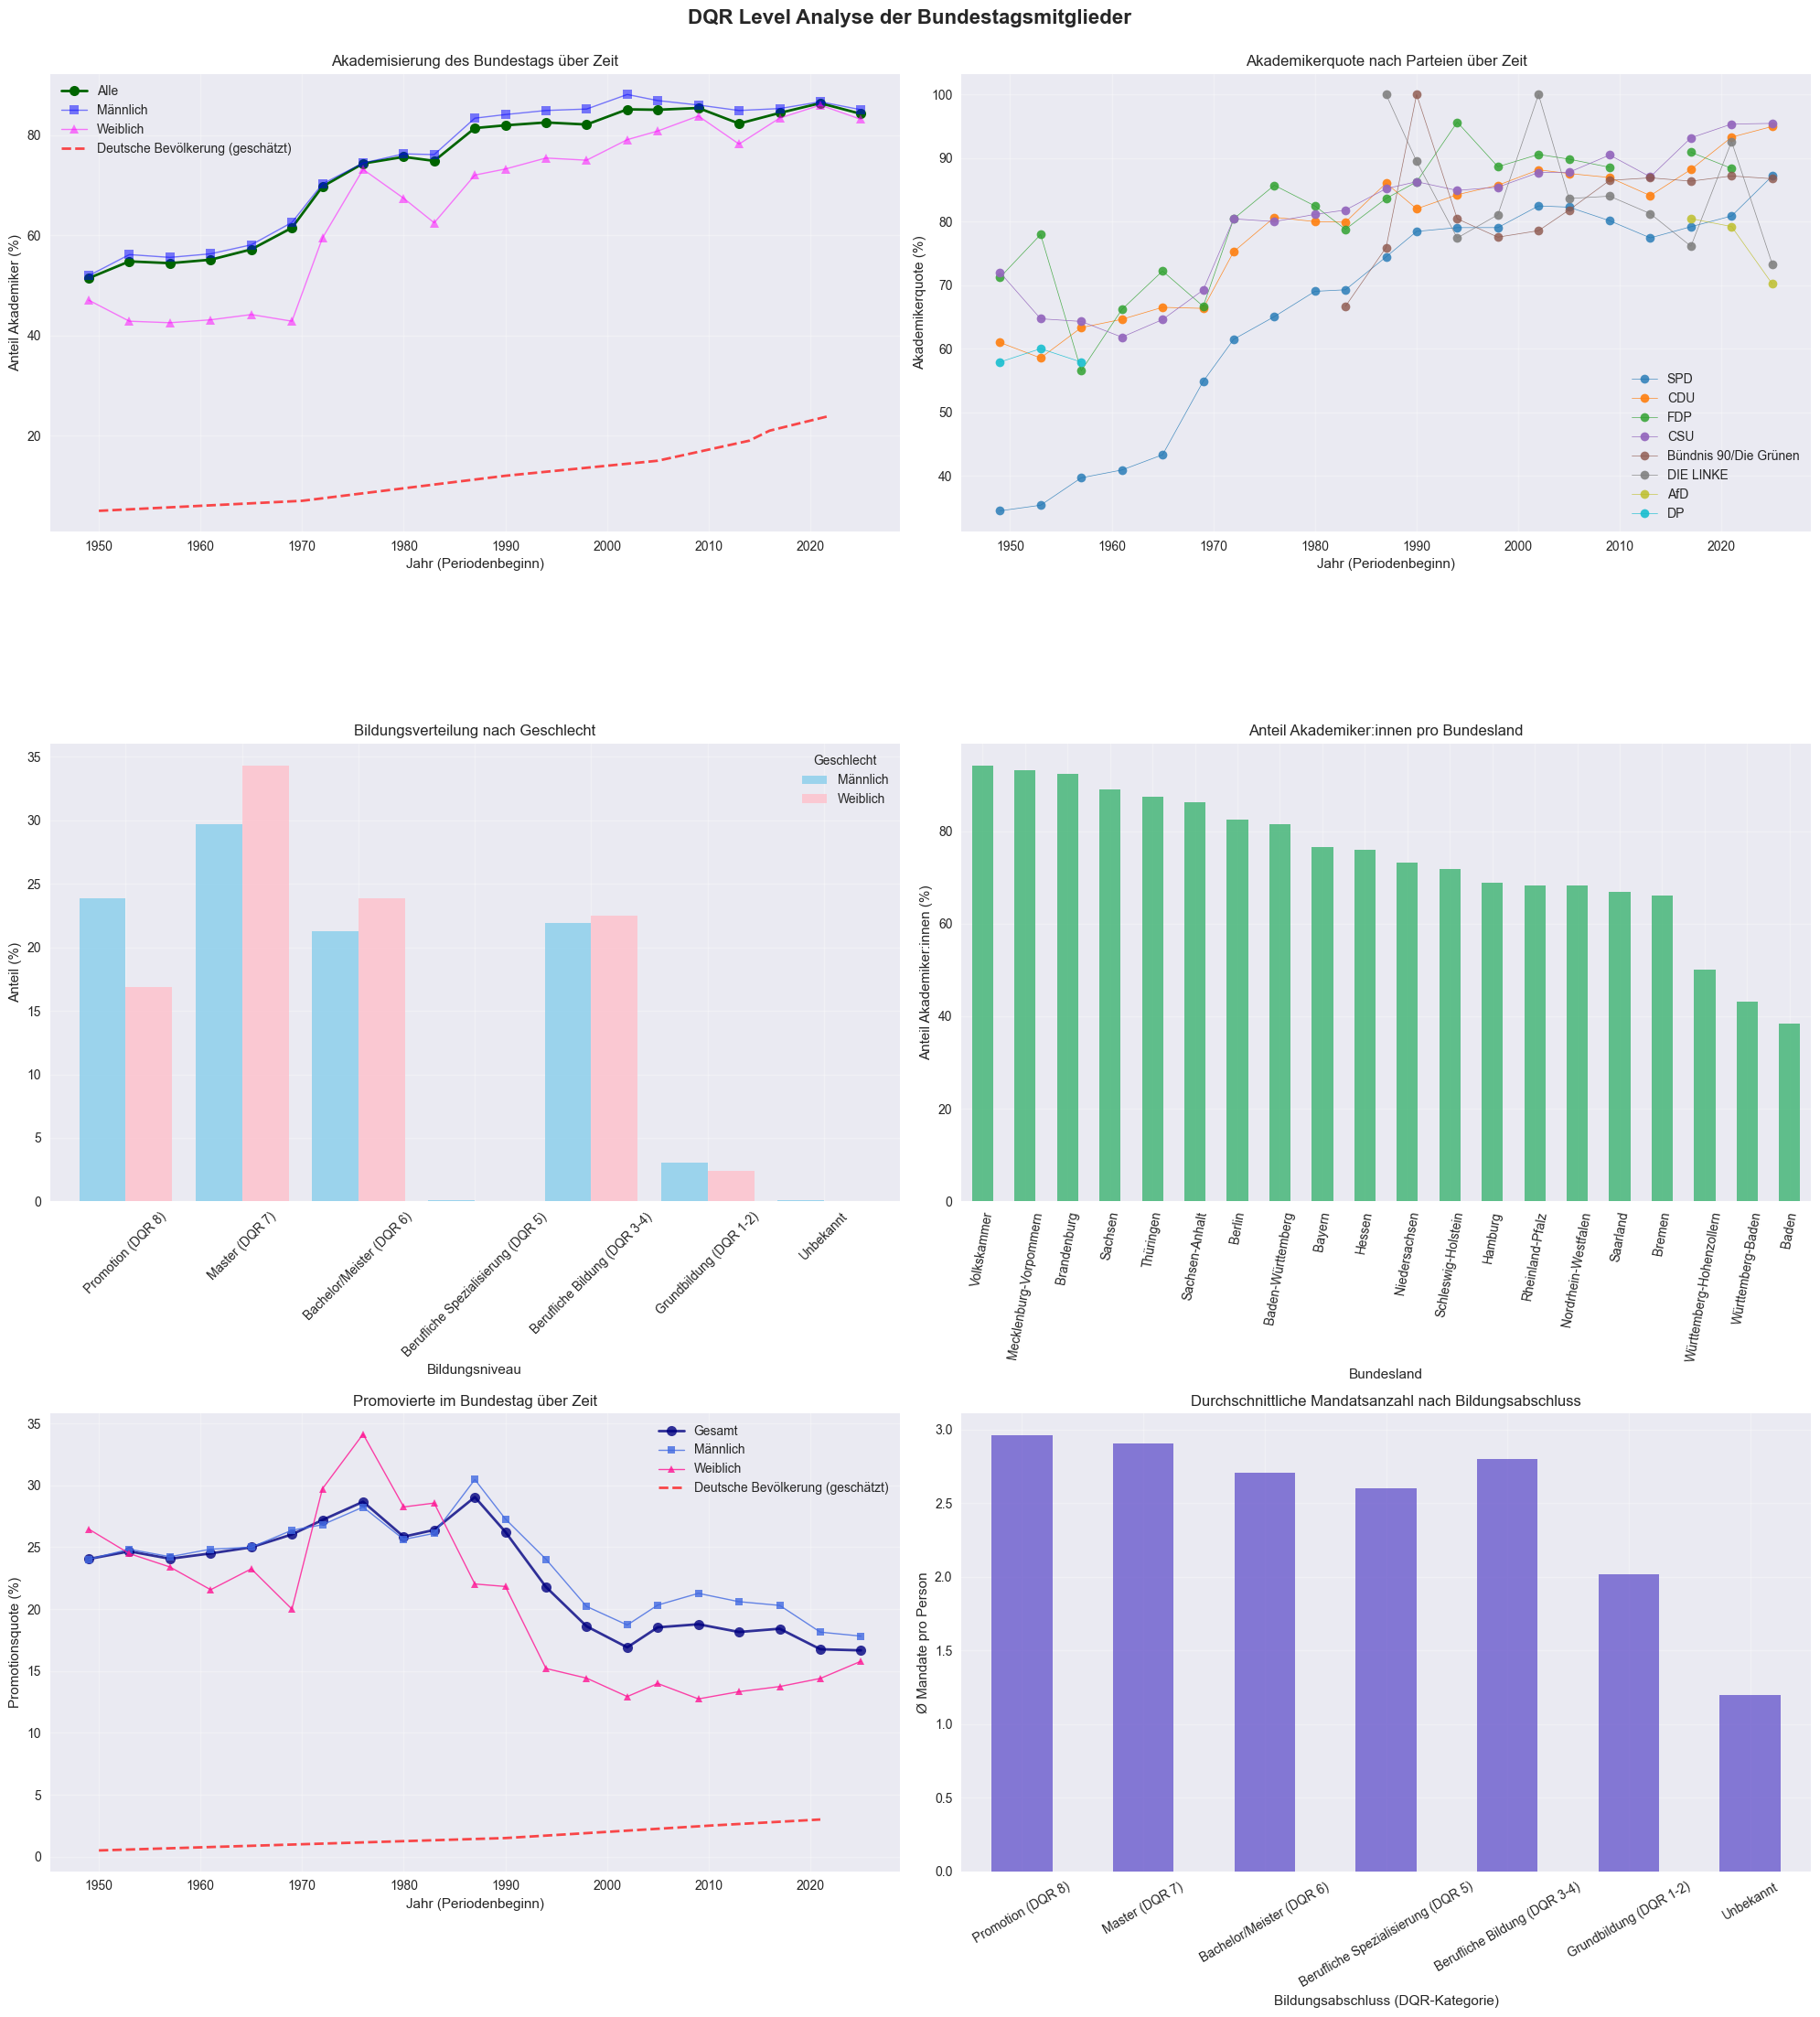

=== NUMERISCHE STATISTIKEN (ERWEITERT) ===
Durchschnittsalter bei Mandatsantritt: 49.1 Jahre
Medianalter bei Mandatsantritt: 50.0 Jahre
Jüngster Abgeordneter: 19 Jahre
Ältester Abgeordneter: 84 Jahre

GESCHLECHTSSPEZIFISCHE ALTERSSTATISTIKEN:
  Divers/Unbekannt: Ø 47.0 Jahre (Median: 47.0, σ: 9.5)
  Männlich: Ø 49.4 Jahre (Median: 50.0, σ: 9.5)
  Weiblich: Ø 48.0 Jahre (Median: 49.0, σ: 9.6)


In [212]:
dqr_level_analysis(df)

In [ ]:
# ==============================================================================
# 3. NUMERISCHE ANALYSEN (ERWEITERT)
# ==============================================================================

def numerical_analysis(df):
    """Führt erweiterte numerische Analysen durch"""
    
    fig, axes = plt.subplots(3, 2, figsize=(20, 22))
    fig.suptitle('Numerische Analyse: Alter und Zeittrends der Bundestagsmitglieder', fontsize=16, fontweight='bold', y=1)
        
    # 1. Altersverteilung pro Wahlperiode (Violin Plot)
    ax1 = axes[0, 0]
    periods_to_plot = sorted(df['period_number'].unique())
    period_ages = []
    period_labels = []
    
    for period in periods_to_plot:
        if not pd.isna(period):
            ages = df[df['period_number'] == period]['age_at_mandate'].dropna()
            period_ages.append(ages.tolist())
            period_labels.append(f'P{int(period)}')
    
    ax1.violinplot(period_ages, positions=range(len(period_ages)), showmeans=True, showmedians=True)
    ax1.set_xticks(range(len(period_labels)))
    ax1.set_xticklabels(period_labels, rotation=45)
    ax1.set_ylabel('Alter bei Mandatsantritt')
    ax1.set_title('Altersverteilung pro Wahlperiode (Violin Plot)')
    ax1.grid(True, alpha=0.3)
    
    # 2. Geschlechterverteilung über Zeit (echte Daten)
    ax2 = axes[0, 1]
    gender_by_year = df.groupby('period_start_year')['gender_normalized'].value_counts(normalize=True).unstack(fill_value=0) * 100

    years = gender_by_year.index
    female_pct = gender_by_year['Weiblich']
    male_pct = gender_by_year.get('Männlich', 0)
        
    ax2.plot(years, female_pct, marker='o', linewidth=3, markersize=8, color='purple', label='Frauenanteil')
    ax2.plot(years, male_pct, marker='s', linewidth=3, markersize=6, color='blue', label='Männeranteil')
        
    ax2.set_xlabel('Jahr (Periodenbeginn)')
    ax2.set_ylabel('Anteil (%)')
    ax2.set_title('Geschlechterverteilung im Zeitverlauf')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # 3. Durchschnittsalter nach Geschlecht über Zeit
    ax3 = axes[1, 0]
    age_gender_time = df.groupby(['period_start_year', 'gender_normalized'])['age_at_mandate'].mean().unstack()

    ax3.plot(age_gender_time.index, age_gender_time['Weiblich'], marker='o', linewidth=2, label='Frauen', color='red')  
    ax3.plot(age_gender_time.index, age_gender_time['Männlich'], marker='s', linewidth=2, label='Männer', color='blue')
        
    ax3.set_xlabel('Jahr (Periodenbeginn)')
    ax3.set_ylabel('Durchschnittsalter')
    ax3.set_title('Durchschnittsalter nach Geschlecht')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    
    # 4. Generationenverteilung
    ax4 = axes[1, 1]
    generation_counts = df['generation'].value_counts()
    colors = plt.cm.Set3(np.linspace(0, 1, len(generation_counts)))
    
    ax4.pie(generation_counts.values, 
                labels=generation_counts.index, 
                autopct='%1.1f%%', colors=colors, 
                startangle=70)
    ax4.set_title('Generationenverteilung aller Mandate')
    
    # 5. Akademisierung über Zeit
    ax5 = axes[2, 0]
    academic_by_year = df.groupby('period_start_year')['is_academic'].mean() * 100
    
    ax5.plot(academic_by_year.index, academic_by_year.values, 
            marker='o', linewidth=3, markersize=8, color='darkgreen')
    ax5.set_xlabel('Jahr (Periodenbeginn)')
    ax5.set_ylabel('Anteil Akademiker (%)')
    ax5.set_title('Akademisierung des Bundestags über Zeit')
    ax5.grid(True, alpha=0.3)
    
    # Deutsche Bevölkerung als Referenz (geschätzte Werte)
    # https://de.wikipedia.org/wiki/Akademikerquote
    # https://www.iwd.de/artikel/der-trend-geht-zum-akademiker-334262/
    ref_years = [1950, 1970, 1990, 2005, 2014, 2016, 2022]
    ref_academic = [5, 7, 12, 15, 19, 21, 24]  # Geschätzte Akademikerquote in Deutschland
    ax5.plot(ref_years, ref_academic, '--', color='red', linewidth=2, 
            label='Deutsche Bevölkerung (geschätzt)', alpha=0.7)
    ax5.legend()
    
    # 6. Alter bei Mandatsantritt vs. Mandatsdauer
    ax6 = axes[2, 1]
    mandate_duration = df.groupby(['firstname', 'lastname']).size()  # Proxy für Mandatsdauer
    first_mandate_age = df.groupby(['firstname', 'lastname'])['age_at_mandate'].min()
    
    # Nur Politiker mit mehreren Mandaten
    multi_mandate = mandate_duration[mandate_duration > 1]
    multi_ages = first_mandate_age[multi_mandate.index]
    
    ax6.scatter(multi_ages, multi_mandate, alpha=0.6, color='orange')
    ax6.set_xlabel('Alter beim ersten Mandat')
    ax6.set_ylabel('Anzahl Mandate')
    ax6.set_title('Alter vs. politische Karrierelänge')
    ax6.grid(True, alpha=0.3)
    
    # Trendlinies
    if len(multi_ages) > 10:
        z = np.polyfit(multi_ages, multi_mandate, 1)
        p = np.poly1d(z)
        ax6.plot(sorted(multi_ages), p(sorted(multi_ages)), "--", color='red', alpha=0.8)



    plt.tight_layout()
    plt.savefig('plots/numerical_analysis.png')
    plt.show()
    
    
    # Erweiterte Statistiken
    print("=== NUMERISCHE STATISTIKEN (ERWEITERT) ===")
    print(f"Durchschnittsalter bei Mandatsantritt: {df['age_at_mandate'].mean():.1f} Jahre")
    print(f"Medianalter bei Mandatsantritt: {df['age_at_mandate'].median():.1f} Jahre")
    print(f"Jüngster Abgeordneter: {df['age_at_mandate'].min():.0f} Jahre")
    print(f"Ältester Abgeordneter: {df['age_at_mandate'].max():.0f} Jahre")
    
    # Geschlechtsstatistiken
    gender_stats = df.groupby('gender_normalized')['age_at_mandate'].agg(['mean', 'median', 'std'])
    print("\nGESCHLECHTSSPEZIFISCHE ALTERSSTATISTIKEN:")
    for gender, stats in gender_stats.iterrows():
        print(f"  {gender}: Ø {stats['mean']:.1f} Jahre (Median: {stats['median']:.1f}, σ: {stats['std']:.1f})")


In [50]:
df[df['age_at_mandate'] <= 20]

,firstname,lastname,full_name,birth_year,death_year,geschlecht,geschlecht_confidence,period_name,period_number,period_start_year,...,current_age,is_deceased,gender_normalized,gender_confidence_category,party_category,party_union,education_category,is_academic,period_epoch,generation
8281,Anna,Luhrmann,Anna Lührmann,1983,<NA>,weiblich,1.0,Liste der Mitglieder des Deutschen Bundestages...,15,2002,...,42,False,Weiblich,Sehr hoch (≥0.9),Bündnis 90/Die Grünen,Bündnis 90/Die Grünen,Promotion (DQR 8),True,Schröder/Merkel I (1998-2013),Millennials (1980-1994)


In [39]:
first_mandate_age = df.groupby(['full_name'])['age_at_mandate'].min()
first_mandate_age['Gerhard Schröder']

np.int64(36)

In [40]:
mandate_duration = df.groupby(['full_name']).size()
mandate_duration[mandate_duration > 10]

full_name
Gerhard Schröder     13
Heinz Riesenhuber    11
Richard Stücklen     11
Wolfgang Schäuble    13
dtype: int64

In [42]:
mandate_duration[mandate_duration > 10]

full_name
Gerhard Schröder     13
Heinz Riesenhuber    11
Richard Stücklen     11
Wolfgang Schäuble    13
dtype: int64

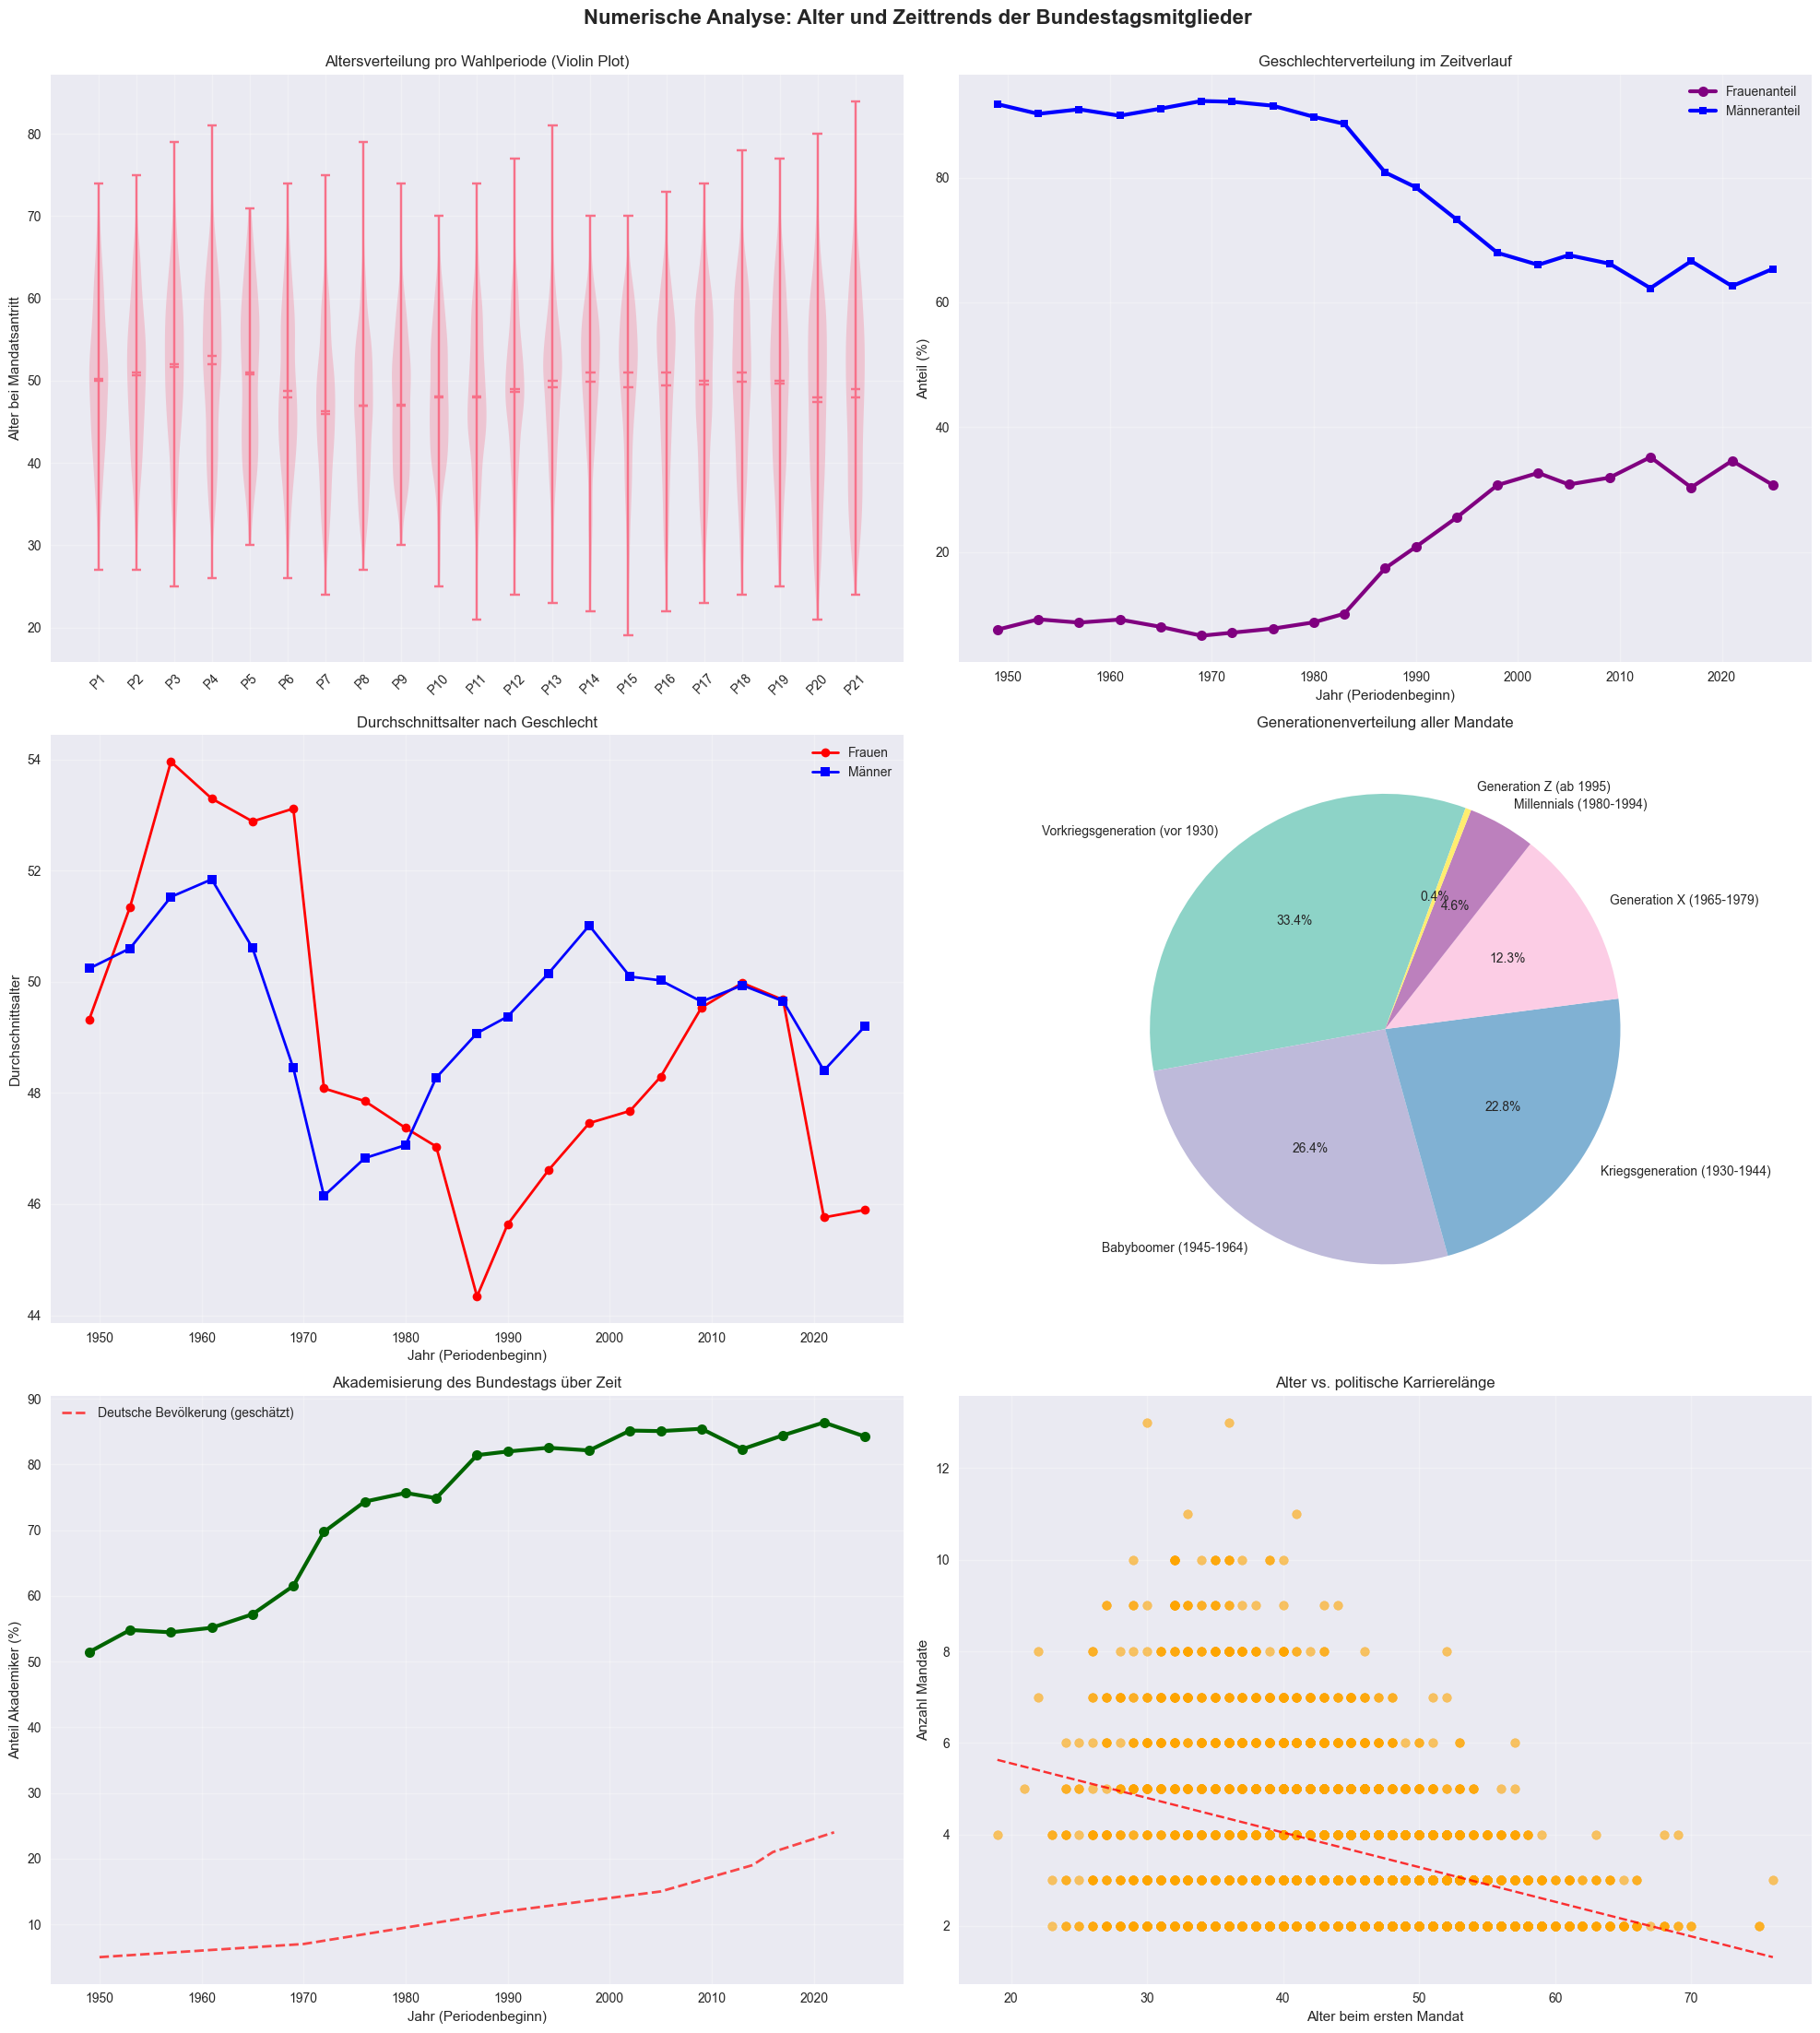

=== NUMERISCHE STATISTIKEN (ERWEITERT) ===
Durchschnittsalter bei Mandatsantritt: 49.1 Jahre
Medianalter bei Mandatsantritt: 50.0 Jahre
Jüngster Abgeordneter: 19 Jahre
Ältester Abgeordneter: 84 Jahre

GESCHLECHTSSPEZIFISCHE ALTERSSTATISTIKEN:
  Divers/Unbekannt: Ø 47.0 Jahre (Median: 47.0, σ: 9.5)
  Männlich: Ø 49.4 Jahre (Median: 50.0, σ: 9.5)
  Weiblich: Ø 48.0 Jahre (Median: 49.0, σ: 9.6)


In [19]:
numerical_analysis(df)

In [100]:
df["education_category"].unique()

array(['Promotion (DQR 8)', 'Berufliche Bildung (DQR 3-4)',
       'Master (DQR 7)', 'Bachelor/Meister (DQR 6)',
       'Grundbildung (DQR 1-2)', 'Berufliche Spezialisierung (DQR 5)',
       'Unbekannt'], dtype=object)

In [101]:
df["dqr_level"].value_counts()

dqr_level
7    3840
8    2809
6    2745
4    2565
0     320
3     178
2      51
5      13
Name: count, dtype: Int64

In [ ]:
# ==============================================================================
# 4. KATEGORIALE ANALYSEN (ERWEITERT)
# ==============================================================================

def categorical_analysis(df):
    """Führt erweiterte kategoriale Analysen durch"""
    
    fig, axes = plt.subplots(3, 2, figsize=(22, 20))
    fig.suptitle('Kategoriale Analyse: Parteien, Geschlecht & Bildung (Erweitert)', 
                 fontsize=16, fontweight='bold', y=1)
    
    # 1. Parteienlandschaft über Zeit (detailliert)
    ax1 = axes[0, 0]
    party_time = pd.crosstab(df['period_start_year'], df['party_category'])
    party_time_pct = party_time.div(party_time.sum(axis=1), axis=0) * 100
    
    # Top 15 Parteien
    main_parties = party_time.sum().nlargest(15).index
    party_time_pct[main_parties].plot(kind='area', stacked=True, ax=ax1, 
                                     colormap='tab20', alpha=0.8)
    ax1.set_xlabel('Jahr (Periodenbeginn)')
    ax1.set_ylabel('Anteil (%)')
    ax1.set_title('Parteienlandschaft im Zeitverlauf')
    ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # 2. Frauenanteil nach Parteien (vertikale Balken, absteigend sortiert)
    ax2 = axes[0, 1]
    women_by_party = df[df['gender_normalized'] == 'Weiblich'].groupby('party_category').size()
    total_by_party = df.groupby('party_category').size()
    women_pct_by_party = (women_by_party / total_by_party * 100).sort_values(ascending=False)

    bars = ax2.bar(women_pct_by_party.index, women_pct_by_party.values, 
                   color='mediumpurple', alpha=0.8)
    ax2.set_xticks(range(len(women_pct_by_party)))
    ax2.set_xticklabels(women_pct_by_party.index, rotation=45, ha='right')
    ax2.set_ylabel('Frauenanteil (%)')
    ax2.set_xlabel('Partei')
    ax2.set_title('Frauenanteil nach Parteien')
    ax2.grid(True, axis='y', alpha=0.3)

    # Werte auf Balken
    for i, bar in enumerate(bars):
        height = bar.get_height()
        if not np.isnan(height):
            ax2.text(bar.get_x() + bar.get_width()/2, height + 0.5, 
                     f'{height:.1f}%', ha='center', va='bottom')
    
    # 3. Bildungsverteilung nach Geschlecht
    ax3 = axes[1, 0]
    education_order = [
        'Promotion (DQR 8)',
        'Master (DQR 7)',
        'Bachelor/Meister (DQR 6)',
        'Berufliche Spezialisierung (DQR 5)',
        'Berufliche Bildung (DQR 3-4)',
        'Grundbildung (DQR 1-2)',
        'Unbekannt'
    ]

    df_gender_filtered = df[df['gender_normalized'].isin(['Weiblich', 'Männlich'])]
    education_gender = pd.crosstab(df_gender_filtered['education_category'], df_gender_filtered['gender_normalized'])
    education_gender = education_gender.reindex(education_order)  # descending order
    education_gender_pct = education_gender.div(education_gender.sum(axis=0), axis=1) * 100
    
    education_gender_pct.plot(kind='bar', ax=ax3, color=['skyblue', 'pink', 'lightgreen'], 
                             width=0.8, alpha=0.8)
    ax3.set_xlabel('Bildungsniveau')
    ax3.set_ylabel('Anteil (%)')
    ax3.set_title('Bildungsverteilung nach Geschlecht')
    ax3.legend(title='Geschlecht')
    ax3.tick_params(axis='x', rotation=45)
    ax3.grid(True, alpha=0.3)
    
    # 4. Akademikerquote nach Parteien über Zeit
    ax4 = axes[1, 1]
    academic_party_time = df.groupby(['period_start_year', 'party_category'])['is_academic'].mean() * 100
    academic_party_time = academic_party_time.unstack()
    
    main_parties_ac = party_time.sum().nlargest(8).index
    for party in main_parties_ac:
        if party in academic_party_time.columns:
            ax4.plot(academic_party_time.index, academic_party_time[party], 
                    marker='o', linewidth=1, label=party)
    
    ax4.set_xlabel('Jahr (Periodenbeginn)')
    ax4.set_ylabel('Akademikerquote (%)')
    ax4.set_title('Akademikerquote nach Parteien über Zeit')
    ax4.legend()
    ax4.grid(True, alpha=0.3)
    
    # 5. Regionale Analyse: Bundesländer
    ax5 = axes[2, 0]
    state_stats = df.groupby('state_name').agg({
        'gender_normalized': lambda x: (x == 'Weiblich').mean() * 100,
        'is_academic': 'mean',
        'age_at_mandate': 'mean'
    }).round(1)
    
    state_stats.columns = ['Frauenanteil (%)', 'Akademikerquote', 'Durchschnittsalter']
    top_states = df['state_name'].value_counts().head(10).index
    state_stats_top = state_stats.loc[state_stats.index.intersection(top_states)]
    
    state_stats_top['Frauenanteil (%)'].plot(kind='bar', ax=ax5, color='coral', alpha=0.8)
    ax5.set_xlabel('Bundesland')
    ax5.set_ylabel('Frauenanteil (%)')
    ax5.set_title('Frauenanteil nach Bundesländern (Top 10)')
    ax5.tick_params(axis='x', rotation=45)
    ax5.grid(True, alpha=0.3)
    
    # 6. Geschlechts-Konfidenz Analyse
    ax6 = axes[2, 1]
    conf_gender = df.groupby('gender_confidence_category')['gender_normalized'].value_counts()
    conf_gender_pct = conf_gender.groupby(level=0).apply(lambda x: x / x.sum() * 100)
    
    conf_data = conf_gender_pct.unstack(fill_value=0)
    conf_data.plot(kind='bar', stacked=True, ax=ax6, color=['lightblue', 'lightpink', 'lightgray'])
    ax6.set_xlabel('Konfidenz der Geschlechtsbestimmung')
    ax6.set_ylabel('Anteil (%)')
    ax6.set_title('Geschlechtsverteilung nach Konfidenz-Level')
    ax6.legend(title='Geschlecht')
    ax6.tick_params(axis='x', rotation=45)

    
    plt.tight_layout()
    plt.savefig('plots/categorical_analysis.png')
    plt.show()
    
    # Kategoriale Statistiken
    print("\n=== KATEGORIALE STATISTIKEN (ERWEITERT) ===")
    total_mandates = len(df)
    unique_politicians = df[['firstname', 'lastname']].drop_duplicates().shape[0]
    
    print(f"Gesamtzahl Mandate: {total_mandates:,}")
    print(f"Eindeutige Politiker: {unique_politicians:,}")
    
    # Geschlechterverteilung
    gender_dist = df['gender_normalized'].value_counts(normalize=True) * 100
    print("\nGESCHLECHTERVERTEILUNG:")
    for gender, pct in gender_dist.items():
        print(f"  {gender}: {pct:.1f}%")
    
    # Parteienverteilung
    party_dist = df['party_union'].value_counts().head(5)
    print("\nTOP 5 PARTEIEN (nach Mandaten):")
    for party, count in party_dist.items():
        pct = count / total_mandates * 100
        print(f"  {party}: {count:,} ({pct:.1f}%)")

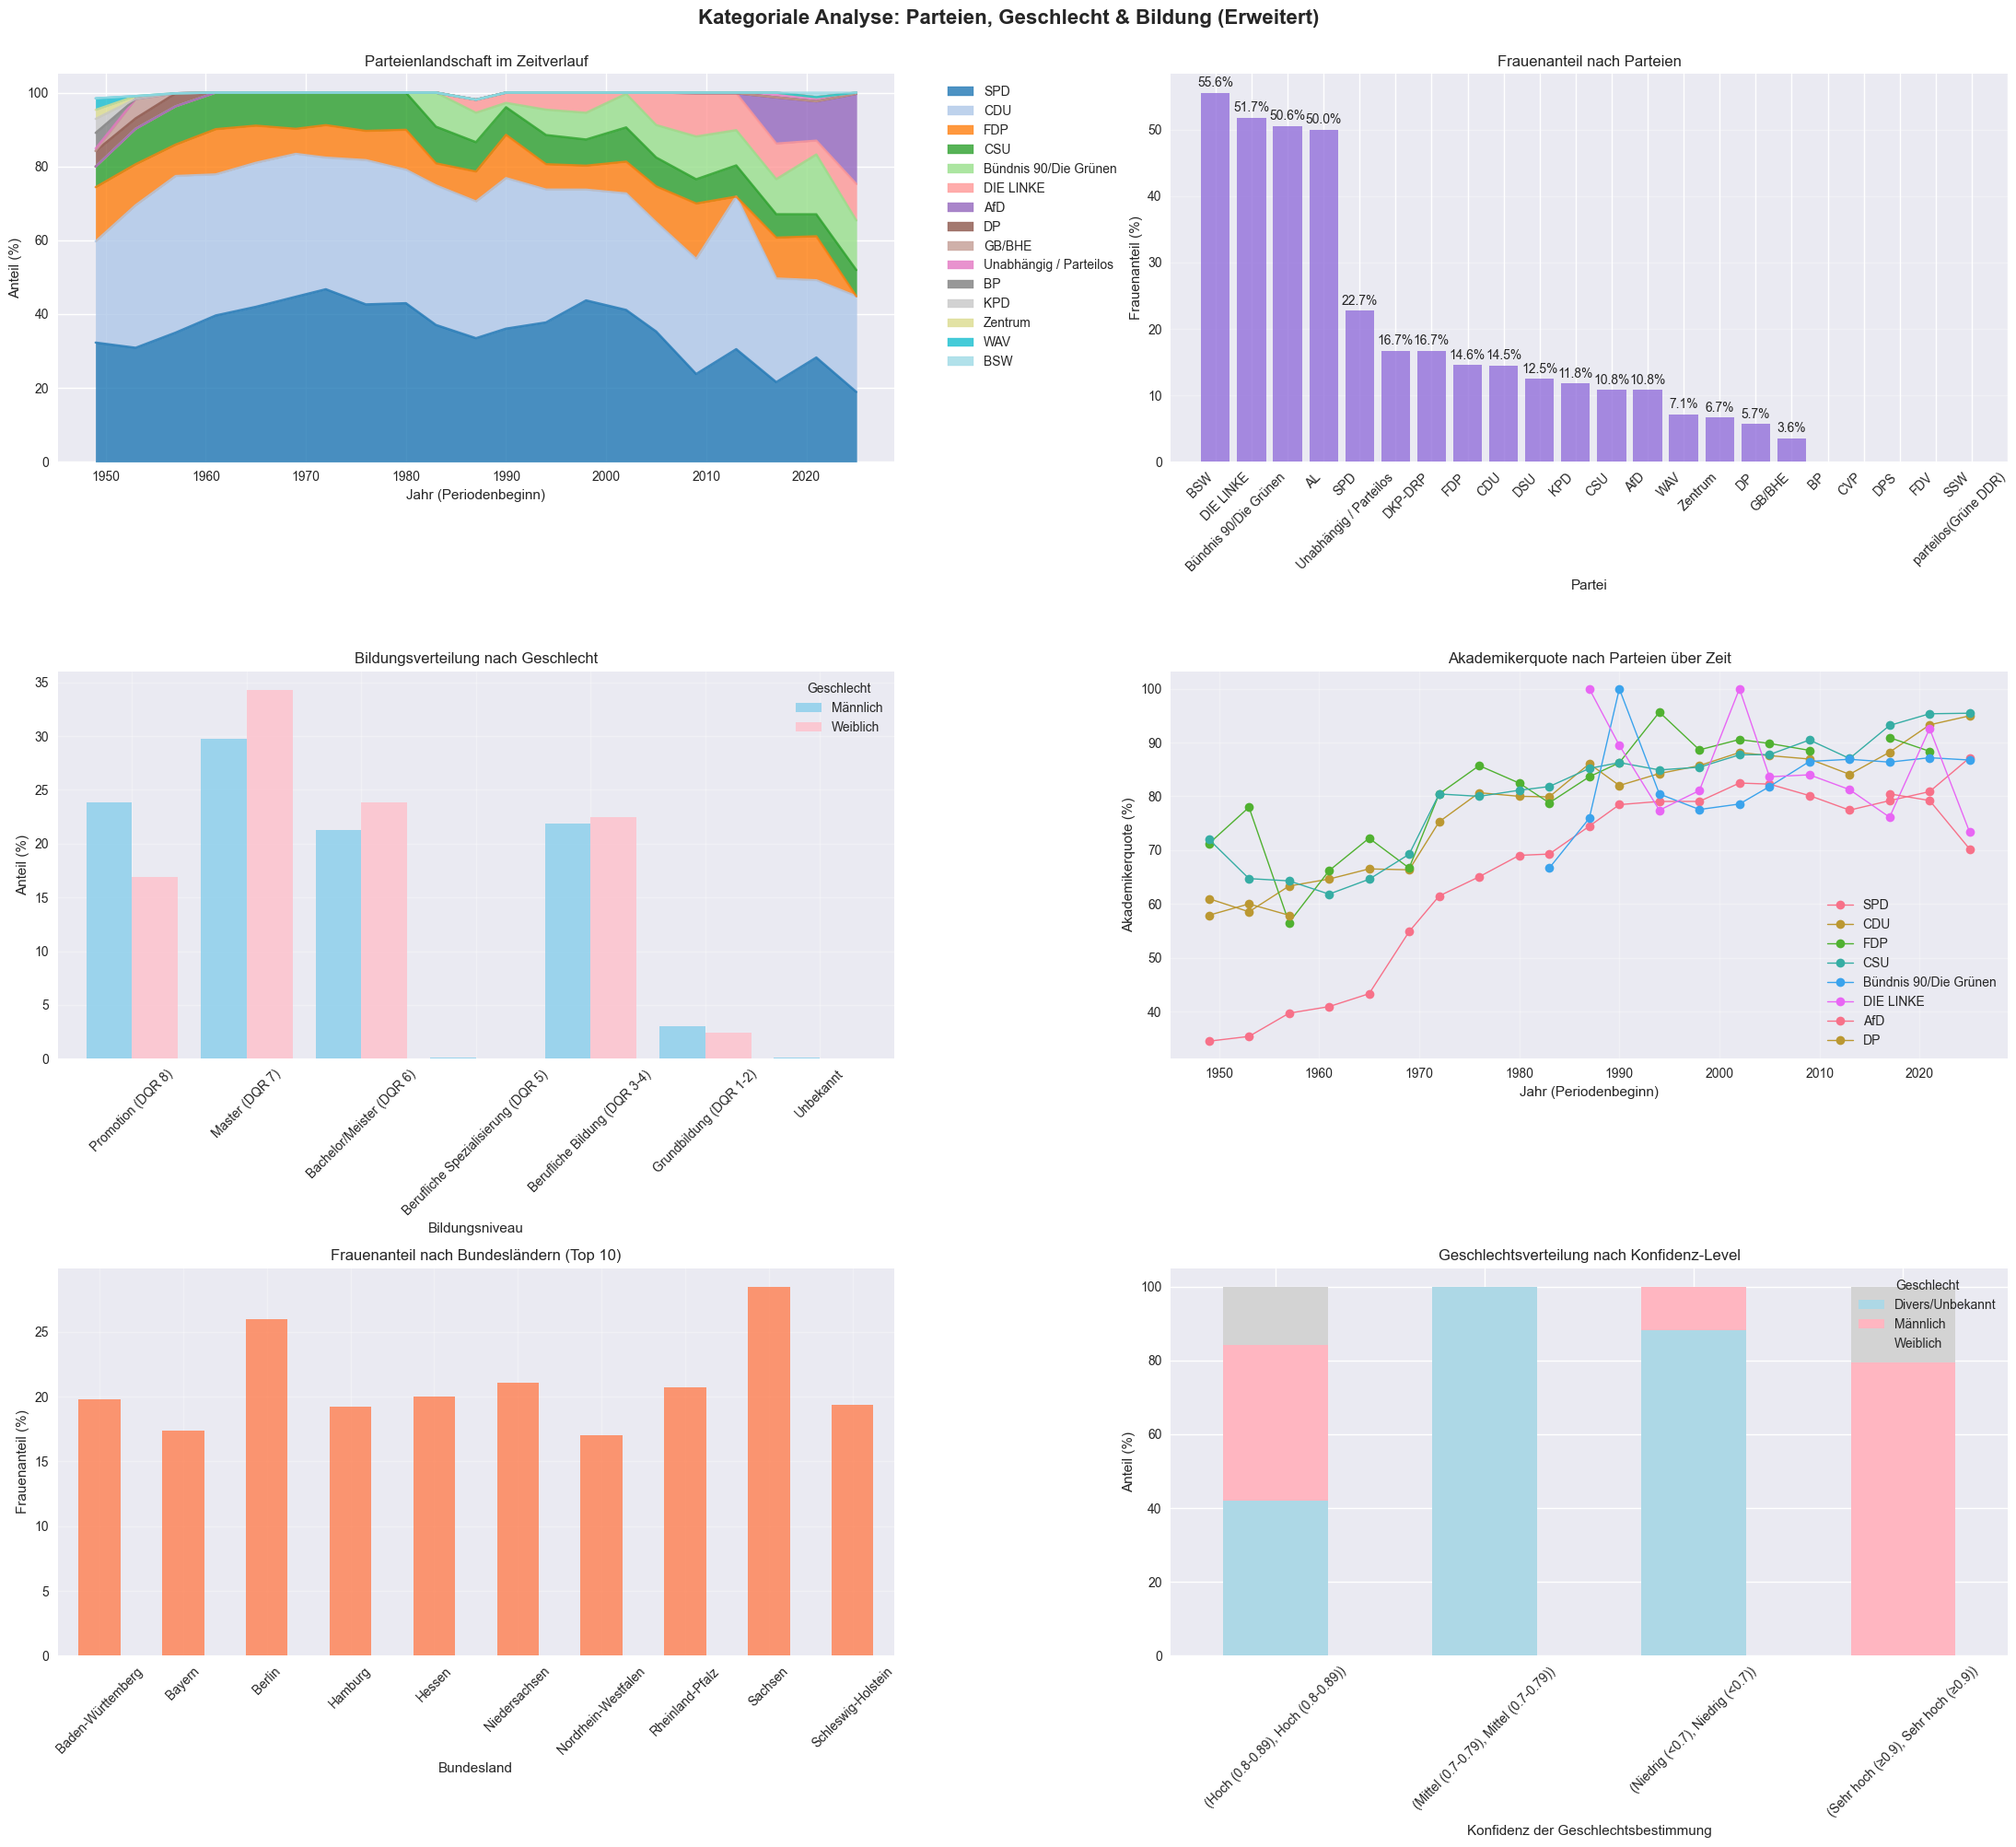


=== KATEGORIALE STATISTIKEN (ERWEITERT) ===
Gesamtzahl Mandate: 12,533
Eindeutige Politiker: 4,448

GESCHLECHTERVERTEILUNG:
  Männlich: 78.1%
  Weiblich: 20.4%
  Divers/Unbekannt: 1.5%

TOP 5 PARTEIEN (nach Mandaten):
  CDU/CSU: 5,331 (42.5%)
  SPD: 4,395 (35.1%)
  FDP: 1,105 (8.8%)
  Bündnis 90/Die Grünen: 720 (5.7%)
  DIE LINKE: 462 (3.7%)


In [145]:
categorical_analysis(df)

In [22]:
# ==============================================================================
# 5. ERWEITERTE ANALYSEN
# ==============================================================================

def advanced_analysis(df):
    """Erweiterte politische und soziodemographische Analysen"""
    
    fig, axes = plt.subplots(3, 2, figsize=(18, 16))
    fig.suptitle('Erweiterte Analysen: Gesellschaftlicher Wandel & Politik', 
                 fontsize=16, fontweight='bold')
    
    # 1. Gender Gap nach Parteien über Zeit
    ax1 = axes[0, 0]
    women_ratio_by_party_time = df[df['period_start_year'] >= 1980].groupby(['period_start_year', 'party_union']).apply(
        lambda x: (x['gender_normalized'] == 'Weiblich').mean() * 100
    ).unstack()
    
    main_parties_gender = ['CDU/CSU', 'SPD', 'FDP', 'Die Grünen']
    colors = ['black', 'red', 'gold', 'green']
    
    for i, party in enumerate(main_parties_gender):
        if party in women_ratio_by_party_time.columns:
            ax1.plot(women_ratio_by_party_time.index, women_ratio_by_party_time[party], 
                    marker='o', linewidth=2.5, label=party, color=colors[i])
    
    ax1.set_xlabel('Jahr (Periodenbeginn)')
    ax1.set_ylabel('Frauenanteil (%)')
    ax1.set_title('Gender Gap: Frauenanteil nach Parteien seit 1980')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Ziellinie bei 50%
    ax1.axhline(y=50, color='gray', linestyle='--', alpha=0.7, label='Parität')
    
    # 2. Altersstruktur: Jung vs. Alt
    ax2 = axes[0, 1]
    age_categories = pd.cut(df['age_at_mandate'], bins=[0, 35, 50, 65, 100], 
                           labels=['Unter 35', '35-49', '50-64', '65+'])
    age_party = pd.crosstab(df['party_union'], age_categories, normalize='index') * 100
    
    main_parties_age = age_party.sum(axis=1).nlargest(4).index
    age_party.loc[main_parties_age].plot(kind='bar', stacked=True, ax=ax2, 
                                        colormap='RdYlBu', alpha=0.8)
    ax2.set_xlabel('Partei')
    ax2.set_ylabel('Anteil (%)')
    ax2.set_title('Altersstruktur nach Parteien')
    ax2.legend(title='Altersgruppe', bbox_to_anchor=(1.05, 1))
    ax2.tick_params(axis='x', rotation=45)
    
    # 3. Bildungsexpansion: Promotion vs. andere Abschlüsse
    ax3 = axes[1, 0]
    phd_ratio_time = df.groupby('period_start_year').apply(
        lambda x: (x['education_category'] == 'Promotion (DQR 8)').mean() * 100
    )
    
    ax3.plot(phd_ratio_time.index, phd_ratio_time.values, 
            marker='o', linewidth=3, markersize=8, color='navy')
    ax3.set_xlabel('Jahr (Periodenbeginn)')
    ax3.set_ylabel('Promotionsquote (%)')
    ax3.set_title('Promovierte im Bundestag über Zeit')
    ax3.grid(True, alpha=0.3)
    
    # Deutsche Bevölkerung als Referenz (geschätzte Promotionsquote)
    ref_years = [1950, 1970, 1990, 2010, 2020]
    ref_phd = [0.5, 1.0, 1.5, 2.5, 3.0]  # Geschätzte Promotionsquote in Deutschland
    ax3.plot(ref_years, ref_phd, '--', color='red', linewidth=2, 
            label='Deutsche Bevölkerung (geschätzt)', alpha=0.7)
    ax3.legend()
    
    # 4. Ost-West Verteilung (nach 1990)
    ax4 = axes[1, 1]
    # Ostdeutsche Bundesländer
    ost_states = ['Brandenburg', 'Mecklenburg-Vorpommern', 'Sachsen', 
                  'Sachsen-Anhalt', 'Thüringen', 'Berlin (Ost)']
    
    df_post_1990 = df[df['period_start_year'] >= 1990].copy()
    df_post_1990['region'] = df_post_1990['state_name'].apply(
        lambda x: 'Ostdeutschland' if x in ost_states else 'Westdeutschland' if pd.notna(x) else 'Unbekannt'
    )
    
    ost_west_time = pd.crosstab(df_post_1990['period_start_year'], 
                               df_post_1990['region'], normalize='index') * 100
    
    if 'Ostdeutschland' in ost_west_time.columns:
        ost_west_time[['Westdeutschland', 'Ostdeutschland']].plot(
            kind='area', stacked=True, ax=ax4, color=['lightblue', 'lightcoral'], alpha=0.8)
        ax4.set_xlabel('Jahr (Periodenbeginn)')
        ax4.set_ylabel('Anteil (%)')
        ax4.set_title('Ost-West Verteilung seit 1990')
        ax4.legend()
        ax4.grid(True, alpha=0.3)
    
    # 5. Karrieremuster: Einstiegsalter vs. Bildung
    ax5 = axes[2, 0]
    education_age = df.groupby('education_category')['age_at_mandate'].mean().sort_values()
    
    bars = ax5.barh(range(len(education_age)), education_age.values, 
                   color='lightsteelblue', alpha=0.8)
    ax5.set_yticks(range(len(education_age)))
    ax5.set_yticklabels(education_age.index)
    ax5.set_xlabel('Durchschnittsalter bei Mandatsantritt')
    ax5.set_title('Einstiegsalter nach Bildungsabschluss')
    ax5.grid(True, alpha=0.3)
    
    # Werte auf Balken
    for i, bar in enumerate(bars):
        width = bar.get_width()
        if not np.isnan(width):
            ax5.text(width + 0.5, bar.get_y() + bar.get_height()/2, 
                    f'{width:.1f}', ha='left', va='center')
    
    # 6. Kontinuität: Mandate pro Politiker
    ax6 = axes[2, 1]
    mandate_counts = df.groupby(['firstname', 'lastname']).size()
    
    ax6.hist(mandate_counts, bins=range(1, min(15, mandate_counts.max()+2)), 
            alpha=0.7, color='darkorange', edgecolor='black')
    ax6.set_xlabel('Anzahl Mandate pro Politiker')
    ax6.set_ylabel('Anzahl Politiker')
    ax6.set_title('Politische Karrierelänge (Mandate pro Person)')
    ax6.grid(True, alpha=0.3)
    
    # Durchschnitt markieren
    avg_mandates = mandate_counts.mean()
    ax6.axvline(avg_mandates, color='red', linestyle='--', linewidth=2, 
               label=f'Durchschnitt: {avg_mandates:.1f}')
    ax6.legend()
    
    plt.tight_layout()
    plt.savefig('plots/advanced_analysis.png')
    plt.show()
    
    # Zusätzliche Statistiken
    print("\n=== ERWEITERTE STATISTIKEN ===")
    print(f"Durchschnittliche Anzahl Mandate pro Politiker: {mandate_counts.mean():.1f}")
    print(f"Politiker mit nur einem Mandat: {(mandate_counts == 1).sum()} ({(mandate_counts == 1).mean()*100:.1f}%)")
    print(f"Politiker mit 5+ Mandaten: {(mandate_counts >= 5).sum()} ({(mandate_counts >= 5).mean()*100:.1f}%)")
    print(f"Längste politische Karriere: {mandate_counts.max()} Mandate")
    
    # Geschlechtsstatistiken
    gender_stats = df['gender_normalized'].value_counts()
    total = len(df)
    print(f"\nGESCHLECHTERVERTEILUNG (ALLE MANDATE):")
    for gender, count in gender_stats.items():
        print(f"  {gender}: {count:,} ({count/total*100:.1f}%)")
    
    # Konfidenz der Geschlechtsbestimmung
    avg_confidence = df['geschlecht_confidence'].mean()
    print(f"\nDurchschnittliche Geschlechts-Konfidenz: {avg_confidence:.3f}")
    
    # Bildungsstatistiken
    academic_overall = df['is_academic'].mean() * 100
    print(f"Gesamtakademikerquote: {academic_overall:.1f}%")
    
    current_period = df[df['period_start_year'] >= 2017]
    if len(current_period) > 0:
        current_academic = current_period['is_academic'].mean() * 100
        current_women = (current_period['gender_normalized'] == 'Weiblich').mean() * 100
        print(f"Aktuelle Periode (ab 2017): {current_academic:.1f}% Akademiker, {current_women:.1f}% Frauen")

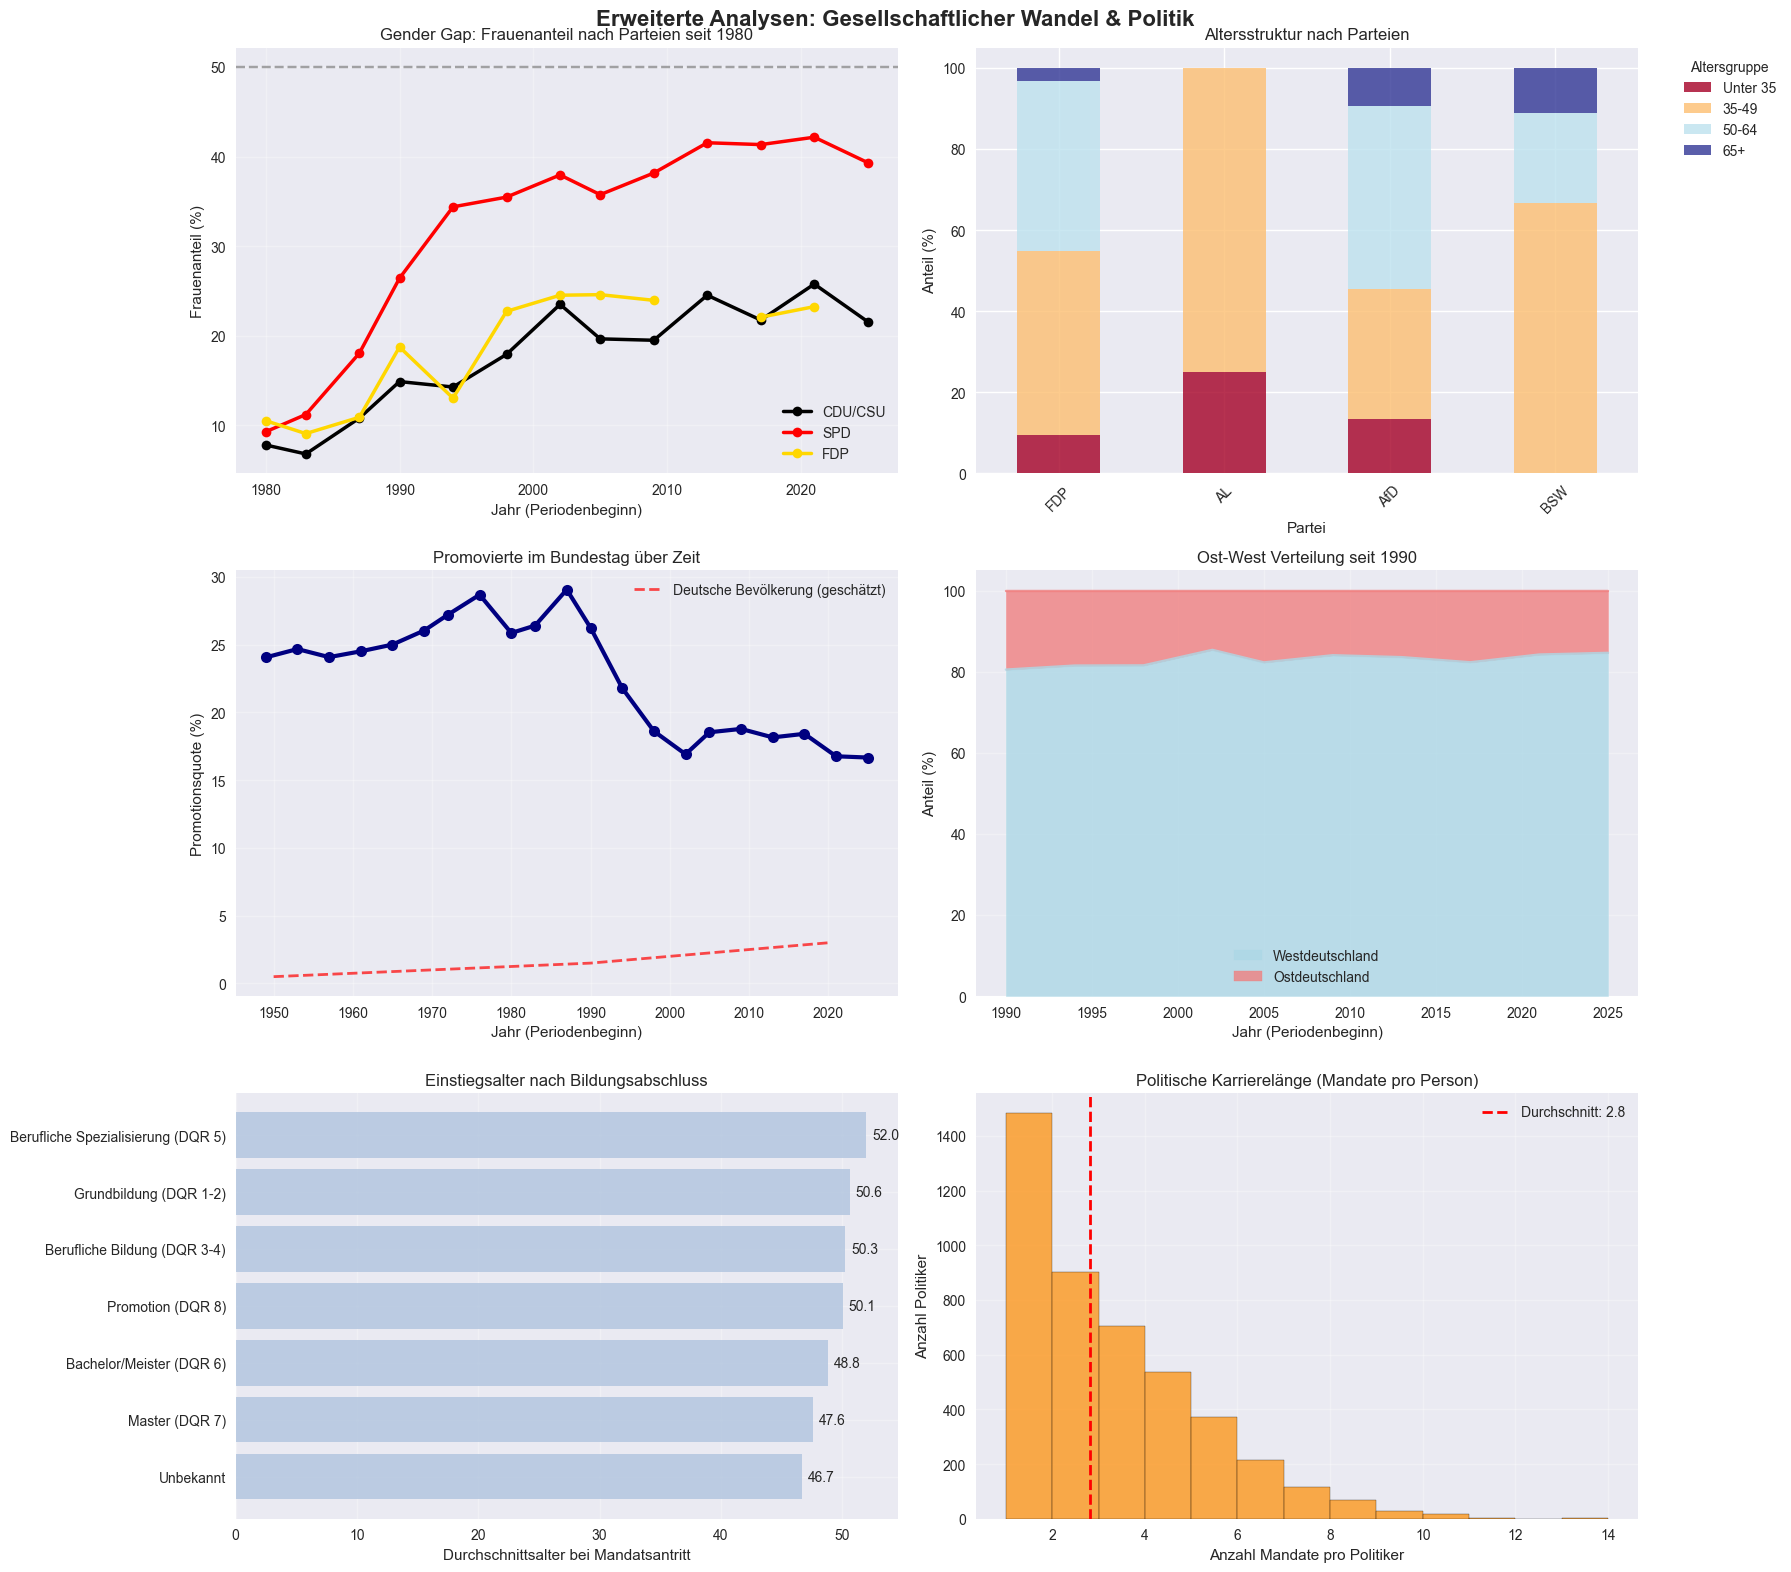


=== ERWEITERTE STATISTIKEN ===
Durchschnittliche Anzahl Mandate pro Politiker: 2.8
Politiker mit nur einem Mandat: 1483 (33.3%)
Politiker mit 5+ Mandaten: 822 (18.5%)
Längste politische Karriere: 13 Mandate

GESCHLECHTERVERTEILUNG (ALLE MANDATE):
  Männlich: 9,789 (78.1%)
  Weiblich: 2,552 (20.4%)
  Divers/Unbekannt: 192 (1.5%)

Durchschnittliche Geschlechts-Konfidenz: 0.952
Gesamtakademikerquote: 75.0%
Aktuelle Periode (ab 2017): 85.1% Akademiker, 32.0% Frauen


In [23]:
advanced_analysis(df)